# IITA

### PREPARATION

In [ ]:
%cd /content/drive/MyDrive/Github/BA
%ls

/content/drive/MyDrive/Github/BA
IITA.ipynb


In [ ]:
# !pip install networkx

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import copy
import pylab as pl
from IPython import display
import time
import re

In [ ]:
# HYPERPARAMETERS
n_items = 7         #10
TAU = 0.07           #.19
num_patterns = 1700  #1900
seed = 7777            #19

## Vocabulary to associate B and items
ids = range(n_items)
nodes = [chr(i+97) for i in range(n_items)]
vocab = {ids[i]: nodes[i] for i in range(len(ids))}

In [ ]:
# HYPER-PARAMETERS of the original study:
# Number of items n : 9
# Error probability τ : 0.03, 0.05, 0.08, 0.10, 0.15, 0.20
# Sample sizes n_samples: 50, 100, 200, 400, 800, 1600, and 6400 are used
# Number of simulations to be averaged: 1000

### Try Original IITA:
### seed336, TAU.03
### seed111, TAU.05
### seed1, TAU.08, n8, m3000

### Try Corrected IITA:
### seed7,77,777, tau.07, n7, m700               ### Slight differences to DAKS results!!
### seed9...

## IITA DATA SIMULATION

### CONSTRUCT & PLOT underlying quasi-order

In [ ]:
def generate_relation(n_items = 9, tau = 0.1, m_samples = 50, seed = None):
  if seed: random.seed(seed)
  items = [chr(i+97) for i in range(n_items)] # adds 97 to iterate over unicode letters a-z

  pairs = []
  for i in range(n_items):
    for j in range(i + 1, n_items):
        pairs.append((items[i], items[j]))

  delta = random.normalvariate(0.16, 0.06)
  delta = max(0, min(delta, 0.3))

  # UNDERLYING QUASI-ORDER
  relation = []
  for pair in pairs:
    if random.random() < delta:
      relation.append(pair)
  # relation = [('a', 'b'), ('a', 'd'), ('b', 'c'), ('d', 'h'), ('e', 'i')]
  elements = sorted(set(e for pair in relation for e in pair))

  # WARSHALL'S ALGORITHM to find TRANSITIVE CLOSURE
  # Initialize the transitive closure matrix
  transitive_closure = {}
  for item in items:
      transitive_closure[item] = set()
      # Add all reflexive pairs to the relation
      transitive_closure[item].add(item)
  # Add direct relations to the transitive closure
  for pair in relation:
      item1, item2 = pair
      transitive_closure[item1].add(item2)                                      # Adds direct relations
  # Compute the transitive closure (dynamic programming approach)
      # Adds j to the set of vertices reachable from i,
      # iff an intermediate vertex k connects i and j
      # (i.e., there is a path from i to j through k)
  for k in elements:
    for i in elements:                                                          # logical consequence (since pair(i,j) <=> iRj <=> j->i)
      for j in elements:                                                        # logical antecedent
        if i != j and k in transitive_closure[i] and j in transitive_closure[k]:
          transitive_closure[i].add(j)                                          # Adds indirect relations iteratively
          #print(f"Adding: {j} to closure of {i} at step {k}")

  quasi_order = [(i, j) for i, values in transitive_closure.items() for j in values]

  #...
  assert len(items) == len(set(items))
  assert len(pairs) == len(set(pairs))
  assert len(relation) == len(set(relation))

  return items, quasi_order



items, true_quasi_order = generate_relation(n_items=n_items, seed=seed)

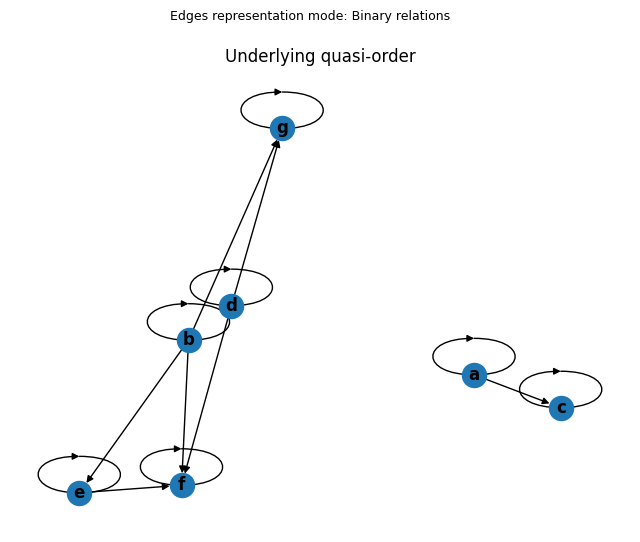

In [ ]:
# Directed Graph for visualization (TODO: realize as Hasse-Diagram)
def viz_relation(items, relation, mode="Binary relations", seed=None, title="Directed Graph of Relation"):
  # Optional: choose to changes direction of graf edges
  if mode == "Implications":
    relation = [(j, i) for i, j in relation]                                    # Depict implications (instead of relation)
  G = nx.DiGraph()
  G.add_nodes_from(items)
  G.add_edges_from(relation)

  plt.figure(figsize=(8, 6))  # Set the figure size
  plt.title(title)
  plt.suptitle(f"Edges representation mode: {mode}", fontsize=9)

  if seed!=None:
    pos = nx.spring_layout(G, seed=seed)
  else:
    pos = nx.spring_layout(G)
  nx.draw(G, pos=pos, with_labels=True, font_weight='bold')

  # time.sleep(2)
  display.clear_output(wait=True)
  display.display(pl.gcf())
  pl.close()



items, true_quasi_order = generate_relation(n_items=n_items, seed=seed)
viz_relation(items, true_quasi_order, seed=seed, title="Underlying quasi-order")

### SAMPLING KNOWLEDGE STATES

#### Methodological approach (TODO)

***In the context of response patterns associated with a quasi-order, if two pairs (i, j) and (k, l) are incomparable, it means that the presence or absence of item i and item j does not affect or determine the presence or absence of item k and item l, and vice versa. They can coexist or be absent independently of each other in the response patterns without violating the quasi-order.***

In [ ]:
# # ANTICHAINS
# antichains = []
# for item1 in quasi_order:
#     is_incomparable = True
#     for item2 in quasi_order:
#         if item1 != item2 and (item1[0] == item2[1] or item1[1] == item2[0]):
#             is_incomparable = False
#             break
#     if is_incomparable:
#         antichains.append(item1)
# # print(quasi_order)
# print(antichains)

In [ ]:
# https://github.com/Kumar-laxmi/Algorithms/blob/main/Python/Maths/closures.py
# def transitiveClosure(relation,n):
#     # Using warshall algorithm
#     relation = [row[:] for row in relation]
#     for k in range(n):
#         for i in range(n):
#             for j in range(n):
#                 # if transitive edge through k then add it to relation
#                 if relation[i][k] == 1 and relation[k][j] == 1:
#                     relation[i][j] = 1
#     print("Transitive closure: ", end='')
#     viz_relation(items, relation)

#### Random Sampling + consistency check

1.   Construct random knowledge states from quasi-order (random binary vector).
2.   Checks consistency, ensuring that the generated knowledge states preserve transitivity according to our relation/quasi-order.





In [ ]:
def sample_knowledge_states(items, quasi_order, num_patterns, seed = None):
    if seed: random.seed(seed)
    knowledge_states = []

    # Generate response patterns by sampling
    index = 0
    while index < num_patterns:
        state = []
        # Generate a binary response for each item
        for item in items:
            response = random.randint(0, 1)
            state.append(response)

        # Check patterns consistency with quasi-order
        is_consistent = all((state[items.index(j)] <= state[items.index(i)]) for i, j in quasi_order)
        # Adds pattern to the list
        if is_consistent:
            knowledge_states.append(state)
            index += 1

    return knowledge_states



states = sorted(sample_knowledge_states(items, true_quasi_order, num_patterns, seed))

# Print the generated response patterns
print("Generated knowledge states:")
for s in np.array(states): print(s)

Generated knowledge states:
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 1 0 0 0]
[0 0 0 1 0 0 0]
[0 0 0 1 0 0 0]
[0 0 0 1 0 0 0]
[0 0 0 1 0 0 0]
[0 0 0 1 0 0 0]
[0 0 0 1 0 0

### SAMPLING RESPONSE PATTERS

In [ ]:
def apply_error(tau = 0.05, seed = None):
    if seed: random.seed(seed)
    patterns = copy.deepcopy(states)
    for state_index, state in enumerate(states):
        for i in range(len(state)):
            if random.random() < tau:
                if state[i]==1: patterns[state_index][i] = 0
                else: patterns[state_index][i] = 1
        # print(patterns[state_index])

    data_matrix = np.array(patterns)
    return data_matrix



D = apply_error(TAU, seed)

print(f"Generated response patterns {D.shape, type(D)}:")
for d in D[:15]: print(d)

Generated response patterns ((1700, 7), <class 'numpy.ndarray'>):
[0 0 0 1 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 1 1 0]
[0 0 0 0 0 0 1]
[0 0 0 0 0 0 0]
[0 0 1 0 0 0 0]
[0 0 0 0 1 0 0]
[0 1 0 1 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[1 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 1 0]
[0 1 0 0 0 0 0]


In [ ]:
diff = np.where(D < np.array(states), 1, np.where(D > np.array(states), 2, 0))
print("Underlying errors of response patterns: ",
      "\n(1 := careless error; 2 := lucky guess) \n")
for row in diff[:15]: print(row)

Underlying errors of response patterns:  
(1 := careless error; 2 := lucky guess) 

[0 0 0 2 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 2 2 0]
[0 0 0 0 0 0 2]
[0 0 0 0 0 0 0]
[0 0 2 0 0 0 0]
[0 0 0 0 2 0 0]
[0 2 0 2 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[2 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 2 0]
[0 2 0 0 0 0 0]


## IITA ALGORITHM

### Inductive Generation

In [ ]:
def counter_examples(D) :
  n = D.shape[1]
  B = np.zeros(shape=(n,n), dtype=int)
  ## iterates through binary implications (i,j) == j->i
  for (i,j), e in np.ndenumerate(B) :
    ## observed response patterns d counterexample of j->i, if j=1 and i=0
    for d in D :
      ## d is a counterexample if j=1 and i=0
      if (d[j] == 1) and (d[i] == 0):
        B[i,j] += 1
  return B

In [ ]:
def transitive(t, R) :
    ## excludes reflexive binaries from set
    R_reduced = [ (i,j) for (i,j) in R if i!=j]
    if R :
      for e in R_reduced :
        ## checks transitivity for t and potential successor of t
        if t[0] == e[1] and (e[0], t[1]) not in R :
          return False
        ## checks transitivity for t and potential predecessor of t
        elif e[0] == t[1] and (t[0], e[1]) not in R :
          return False
    return True

In [ ]:
def construct_relations(B, m):
  relations = []
  current = []

  ## Constructs one model (quasi-order) for each tolerance level L
  for L in range(m):
    if relations:
      current = relations[-1]

    ## Potential implications (i,j) in A
    ##   for the current relation (quasiorder)
    ##   with associated tolerance level l <= L
    A1 = []                                                                     ### TODO...
    for (i,j),_ in np.ndenumerate(B):
      if (B[i,j] < L+1) and ((vocab[i],vocab[j]) not in current):
        A1 += [(vocab[i],vocab[j])]
    ## excludes implications that cause intransitivity to potential new relation (quasi-order)
    A2 = []
    for (i,j) in A1:
      if transitive((i,j), current + A1):  ###### ...  all((state[items.index(j)] <= state[items.index(i)]) for i, j in quasi_order)  ...
        A2 += [(i,j)]

    next_r = current + A2
    ## store new models (quasi-orders)
    # if A2:
      # if next_r not in relations:
    relations += [next_r]

  return relations

In [ ]:
# Test counter_examples()
b_ij = counter_examples(D)
for b in b_ij:
  print(b)

# Test transitive()
transitive(('a','e'), true_quasi_order)

[  0 464  83 433 312 164 197]
[256   0 153 238  84  51  73]
[590 868   0 769 571 288 369]
[359 372 188   0 219  61  65]
[532 512 284 513   0  89 228]
[809 904 426 780 514   0 337]
[725 809 390 667 536 220   0]


False

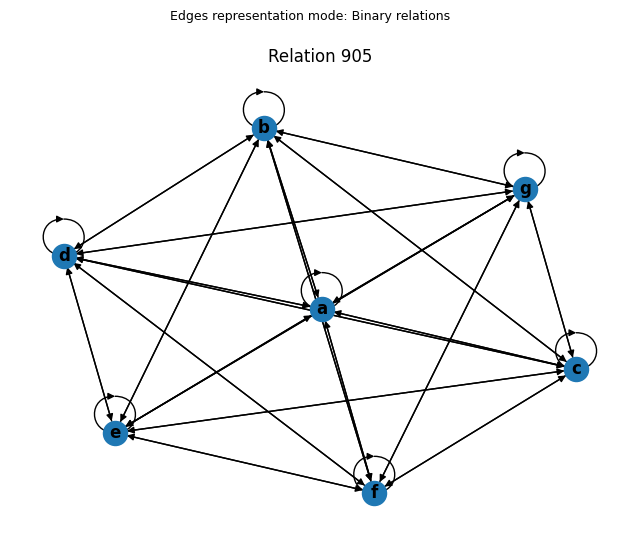

In [ ]:
selection_set = construct_relations(b_ij, D.shape[0])

previous = []
for i, R in enumerate(selection_set):
    title = f"Relation {i+1}"
    if previous != R:
      viz_relation(items, R, mode="Binary relations", seed=seed, title=title)
      previous = R

### Fitting the models

#### Methods

In [ ]:
### Calculates and stores the error of each quasi-order with the data matrix
def original_errors(D, B, selection_set) :
  n = D.shape[1]
  m = D.shape[0]
  ## Frequencies P of items in data samples
  P = D.sum(axis = -2) / m
  errors = []

  for R in selection_set :
    gamma = 0

    ### ...
    for (i,j), _ in np.ndenumerate(B) :
      if (vocab[i],vocab[j]) in R and i!=j :
        gamma += (B[i,j] / (P[j] * m))                                          ### (+= Number of observed counterexamples to (i,j) relative to the number of cases in which such a counterexample is possible)

    ### ...
    if len(R) - n > 0:
      ## normalization by number of non-reflexive implications in R
      errors += [gamma / (len(R) - n)]
    else :
      errors += [1]                                                             # Default error value when there are no implications

  return errors

In [ ]:
### Calculates and stores the error of each quasi-order with the data matrix
def minimized_errors(D, B, selection_set) :
  n = D.shape[1]
  m = D.shape[0]
  ## Frequencies P of items in data samples
  P = D.sum(axis = -2) / m
  errors = []

  for R in selection_set :
    x1, x2, x3, x4 = [0,0,0,0]

    ### ...
    for (i,j), _ in np.ndenumerate(B) :
      if i!=j:

        if (vocab[i],vocab[j]) not in R and (vocab[j],vocab[i]) in R :
          x1 += (-2 * B[i,j] * P[i] * m +
                  2 * P[i] * P[j] * (m**2) -
                  2 * (P[i]**2) * m**2 )
          x3 += 2 * P[i]**2 * m**2

        if (vocab[i],vocab[j]) in R :
          x2 += -2 * B[i,j] * P[j] * m
          x4 += 2 * P[j]**2 * m**2

    ### ...
    if x3 == 0 or x4 == 0:
      gamma = 1  # Set gamma to 1 for division by zero cases
    else:
      gamma = -1 * ((x1+x2) / (x3+x4))

    if len(R) - n > 0:
      errors += [gamma]
    else :
      errors += [1]                                                         # Default error value when there are no implications

  return errors

In [ ]:
### Calculates an expected number of counterexamples for each binary
def original_expectation(D, B, quasi_orders, errors) :
  if np.any(np.apply_along_axis(np.sum, axis=0, arr=D) == 0):                 # 1) Each item solved
    raise ValueError("each item must be solved at least once")

  n = D.shape[1]
  m = D.shape[0]
  P = D.sum(axis = -2) / m
  Targets = np.zeros(shape=(1, n, n))
  print(n, m, P)

  for R_index, R in enumerate(quasi_orders) :
    if R_index > 0:
      t = np.zeros(shape=(1, n, n))

    ####################################
      for (i,j), _ in np.ndenumerate(B) :
        if (vocab[i],vocab[j]) not in R and i!=j:
          ## ...
          t[:,i,j] = (1 - P[i]) * P[j] * m * (1 - errors[R_index])
        if (vocab[i],vocab[j]) in R and i!=j :
          ## ...
          t[:,i,j] = errors[R_index] * P[j] * m
    ####################################

      # print(f"target at step {R_index}: {t}")
      Targets = np.concatenate( (Targets, t), axis=0)

  return copy.deepcopy(Targets)

In [ ]:
def corrected_expectation(D, B, quasi_orders, errors) :
  if np.any(np.apply_along_axis(np.sum, axis=0, arr=D) == 0):                 # 1) Each item solved
    raise ValueError("each item must be solved at least once")

  n = D.shape[1]
  m = D.shape[0]
  P = D.sum(axis = -2) / m
  Targets = np.zeros(shape=(1, n, n))
  print(n, m, P)

  for R_index, R in enumerate(quasi_orders) :
    if R_index > 0:
      t = np.zeros(shape=(1, n, n))

    ####################################
      for (i,j), _ in np.ndenumerate(B) :
        if (vocab[i],vocab[j]) not in R and (vocab[j],vocab[i]) not in R:       ### (Sargin & Ünlü, 2009)
          ## ...
          t[:,i,j] = (1 - P[i]) * P[j] * m
        elif (vocab[i],vocab[j]) not in R and (vocab[j],vocab[i]) in R:
          ## ...<
          t[:,i,j] = (P[j] - (P[i] - (P[i] * errors[R_index]) )) * m
        elif (vocab[i],vocab[j]) in R and i!=j :
          ## ...
          t[:,i,j] = errors[R_index] * P[j] * m

          if (P[j] - (P[i] - (P[i] * errors[R_index])) < 0):                    ### (Ünlü & Schrepp, 2020)
            t[:,i,j] = 0

    ####################################

      # print(f"target at step {R_index}: {t}")
      Targets = np.concatenate( (Targets, t), axis=0)

  return Targets

In [ ]:
### Calculates and stores the distance measure of each quasi-order with the data matrix
def difference(B, Targets) :
  n = B.shape[0]
  difference_values = []
  diff = 0

  for index, _ in enumerate(Targets) :
    sum = 0

    for (i,j), b in np.ndenumerate(B) :
      if i!=j :
        sum += (b - Targets[index,i,j]) ** 2
    # diff = sum / (n**2 - n)                                                    ### (Sargin & Ünlü, 2009)
    diff = sum / (2*n * (2 * (n-1)))                                            ### (Ünlü & Schrepp, 2020)

    difference_values += [diff]

  return difference_values

#### Calculations

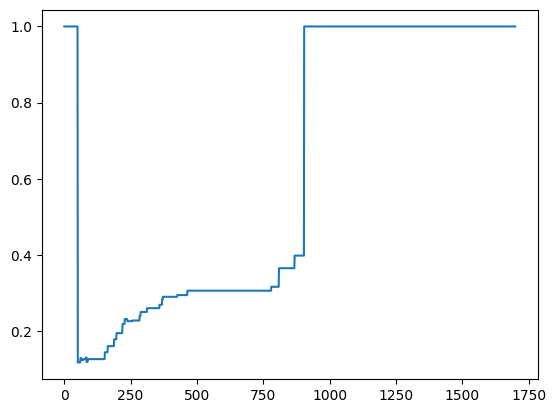

7 1700 [0.63352941 0.75588235 0.33529412 0.67705882 0.50411765 0.25411765
 0.32294118]


In [ ]:
# errors = original_errors(D, b_ij, selection_set)
errors = minimized_errors(D, b_ij, selection_set)                                ### TODO
plt.plot(errors)
plt.show()

# estimates = original_expectation(D, b_ij, selection_set, errors)
estimates = corrected_expectation(D, b_ij, selection_set, errors)

In [ ]:
# temp = 0
# # prints each estimate b_ij* ("Targets")
# previous = -np.ones(shape=estimates[0].shape)
# for i,T in enumerate(estimates):
#   print(f"Estimate at level L={i+1}")
#   if not (np.all(previous == T)):
#     for row in T:
#       print( np.round(row.astype(float), 4) )
#   else:
#     print(f"----- L={i+1}: same -----")
#   previous = T
# print("\n")

[1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318, 1018.0687139479318,

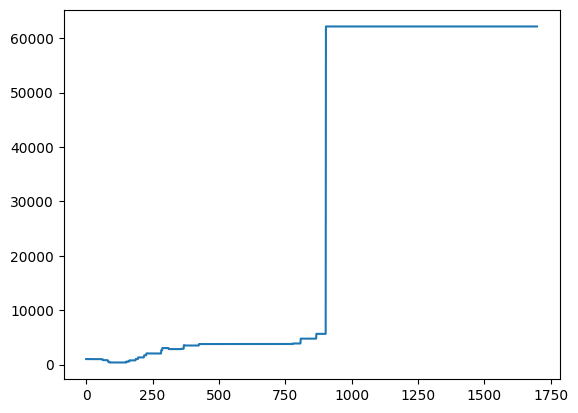

In [ ]:
fit = difference(b_ij, estimates[1:,:,:])
print(fit)
plt.plot(fit)
plt.show()

## Solution

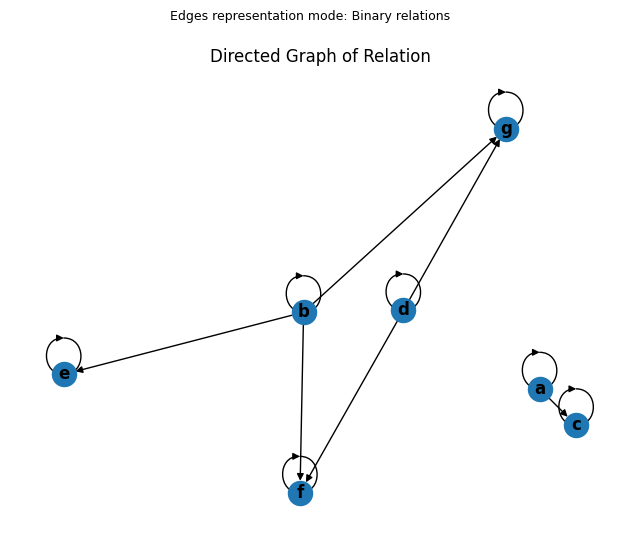

Missing/False implications: {('e', 'f')}


In [ ]:
### Selects the best fitting model
def evaluate(quasi_orders, difference_values) :
  indices = [index for index, item in enumerate(difference_values) if item == min(difference_values)]
  return quasi_orders[indices[0]]

# solution

viz_relation(items, solution, mode="Binary relations", seed=seed)
print(f"Missing/False implications: {set(true_quasi_order).difference(solution)}")

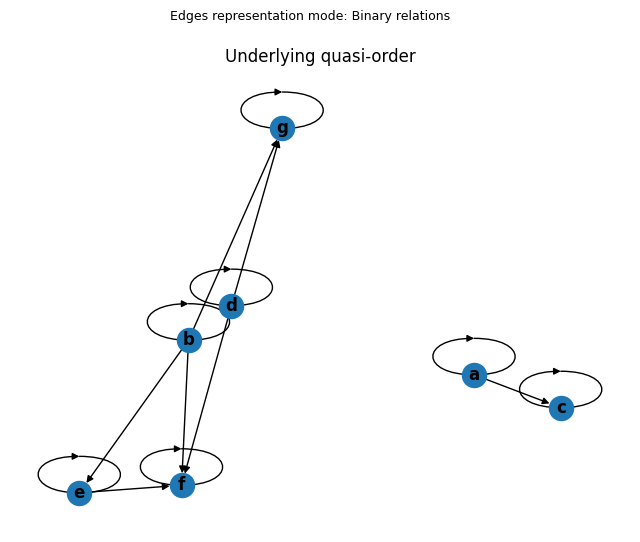

In [ ]:
viz_relation(items, true_quasi_order, seed=seed, title="Underlying quasi-order")

In [ ]:
print(true_quasi_order)

[('a', 'c'), ('a', 'a'), ('b', 'b'), ('b', 'e'), ('b', 'g'), ('b', 'f'), ('c', 'c'), ('d', 'd'), ('d', 'f'), ('d', 'g'), ('e', 'e'), ('e', 'f'), ('f', 'f'), ('g', 'g')]


In [ ]:
no_reflexives = [b for b in true_quasi_order if b[0]!=b[1]]
print(no_reflexives)

[('a', 'c'), ('b', 'e'), ('b', 'g'), ('b', 'f'), ('d', 'f'), ('d', 'g'), ('e', 'f')]


## Validation (with DAKS results)

In [ ]:
re_dict = {value: key for key, value in vocab.items()}
print( ', '.join(sorted([f"tuple({re_dict[i]+1},{re_dict[j]+1})" for (i,j) in no_reflexives])) )

tuple(1,3), tuple(2,5), tuple(2,6), tuple(2,7), tuple(4,6), tuple(4,7), tuple(5,6)


In [ ]:
R_output0 = "{(3L, 6L), (3L, 7L), (4L, 6L), (4L, 7L), (6L, 7L)}"
R_output1 = re.findall(r'\d+', R_output0) #[(i,j) for re.findall(r'\d+', R_output)]   ### [(numbers[i], numbers[i + 1]) for i in range(0, len(numbers), 2)]
R_output2 = [(int(R_output1[i])-1,int(R_output1[i+1])-1) for i in range(0, len(R_output1), 2)]
R_solution = [(vocab[i],vocab[j]) for (i,j) in R_output2]
print(R_solution)

[('c', 'f'), ('c', 'g'), ('d', 'f'), ('d', 'g'), ('f', 'g')]


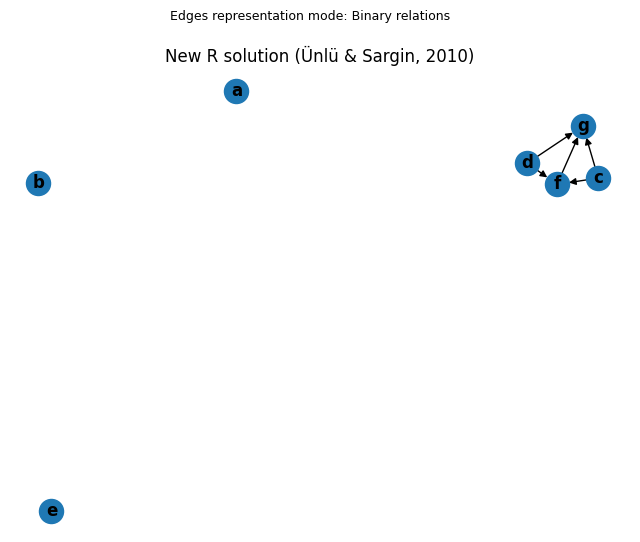

Missing/False implications: {('b', 'g'), ('e', 'e'), ('b', 'e'), ('a', 'c'), ('e', 'f'), ('b', 'f'), ('c', 'c'), ('g', 'g'), ('d', 'd'), ('a', 'a'), ('f', 'f'), ('b', 'b')}


In [ ]:
viz_relation(items, R_solution, seed=seed, title="New R solution (Ünlü & Sargin, 2010)")
print(f"Missing/False implications: {set(true_quasi_order).difference(R_solution)}")